<a href="https://colab.research.google.com/github/xli2522/GW-SignalGen/blob/main/modified_S.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<img style="float: left;padding: 1.3em" src="https://indico.in2p3.fr/event/18313/logo-786578160.png">  
#  Modified S Transform
#####(for GW Signal Analysis) 
##### © Xiyuan Li 2021, Department of Physics and Astronomy, Western University (UWO), London, Ontario, Canada
##### Resources: 
[PyCBC](http://github.com/ligo-cbc/pycbc) + additional PyCBC [examples](http://pycbc.org/pycbc/latest/html/#library-examples-and-interactive-tutorials) and module level documentation are [here](http://pycbc.org/pycbc/latest/html/py-modindex.html).<br>
[GWpy](https://gwpy.github.io/docs/stable/)
##### Paper Reference:
[Generalizing the inverse FFT of the unit circle, V. Sukhoy, A. Stoytchev, 2019](https://www.nature.com/articles/s41598-019-50234-9)<br>
[THE DISCRETE LINEAR CHIRP TRANSFORM AND ITS APPLICATIONS, O. Alkishriwo, 2013](http://d-scholarship.pitt.edu/17769/3/Alkishriwo_etdPitt2013.pdf)

##### Code Reference:
[gw-odw/odw-2020](http://github.com/gw-odw/odw-2020)<br> 
[Scipy](https://docs.scipy.org/doc/scipy/reference/index.html)<br> 
[Chirp Z Transform](https://github.com/garrettj403/CZT)

## 1 Generate GW Waveforms

### 1.1 Generate Clean BBH Waveforms

In [3]:
# -- Use the following line if running in Google Colab
! pip install -q 'PyCBC==1.15.3' 'lalsuite==6.66'

In [4]:
# Initialization
%matplotlib inline

from pycbc.waveform import get_td_waveform
import pylab
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn as learn
import time
import tqdm    #progress bar

In [5]:
# specify the sample rate ==> the same from above
sample_rate = 4096 # samples per second
data_length = 1024 # seconds

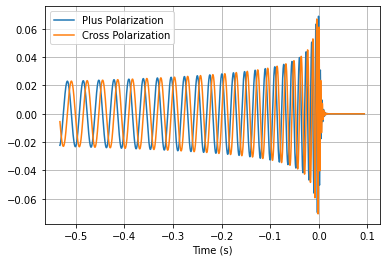

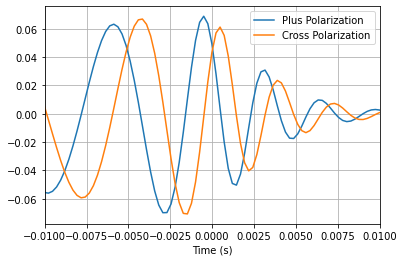

In [6]:
# Generating one example waveform 
# The output of this function are the "plus" and "cross" polarizations of the gravitational-wave signal 
# as viewed from the line of sight at a given source inclination (assumed face-on if not provided)
hp, hc = get_td_waveform(approximant="SEOBNRv4_opt",
                         mass1=40,
                         mass2=10,
                         delta_t=1.0/sample_rate,
                         f_lower=30,
                         distance=5)

hp = hp / max(np.correlate(hp, hp, mode='full'))**0.5
hc = hc / max(np.correlate(hc, hc, mode='full'))**0.5

pylab.plot(hp.sample_times, hp, label='Plus Polarization')
pylab.plot(hp.sample_times, hc, label='Cross Polarization')
pylab.xlabel('Time (s)')
pylab.legend()
pylab.grid()
pylab.show()

# Zoom in near the merger time#
pylab.plot(hp.sample_times, hp, label='Plus Polarization')
pylab.plot(hp.sample_times, hc, label='Cross Polarization')
pylab.xlabel('Time (s)')
pylab.xlim(-.01, .01)
pylab.legend()
pylab.grid()
pylab.show()

# verify container type and data extraction
testing_container = np.zeros(2, dtype=object)
testing_container[0], testing_container[1] = hp, hc

# hp and hc are clean BBH GW signals

### 1.2 Generate BBH Waveforms with Gaussian Noise

Text(0, 0.5, 'Normalized amplitude')

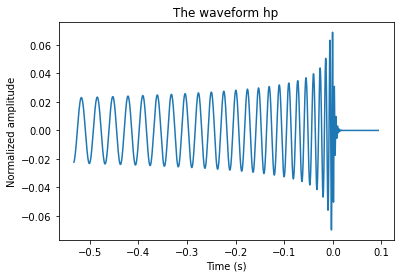

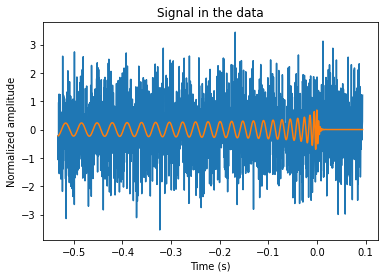

In [7]:
# Generate a long stretch of white noise: the data series and the time series.
data = np.random.normal(size=[sample_rate * data_length])
times = np.arange(len(data)) / float(sample_rate)

# note that in this figure, the waveform amplitude is of order 1.
# The duration (for frequency above f_lower=25 Hz) is only 3 or 4 seconds long.
# The waveform is "tapered": slowly ramped up from zero to full strength, over the first second or so.
# It is zero-padded at earlier times.

# plot the clean signal
pylab.figure()
pylab.title("The waveform hp")
pylab.plot(hp.sample_times, hp)
pylab.xlabel('Time (s)')
pylab.ylabel('Normalized amplitude')

# Shift the waveform to start at a random time in the Gaussian noise data.
waveform_start = np.random.randint(0, len(data) - len(hp))

# combine the noise data with *rescaled* clean BBH signal
data[waveform_start:waveform_start+len(hp)] += 10 * hp.numpy()

pylab.figure()
pylab.title("Signal in the data")
pylab.plot(hp.sample_times, data[waveform_start:waveform_start+len(hp)])
pylab.plot(hp.sample_times, 10 * hp)
pylab.xlabel('Time (s)')
pylab.ylabel('Normalized amplitude')

## 2 Spectrograms

#### 2.1 Default STFT Scipy

In [8]:
from scipy import signal as scisignal

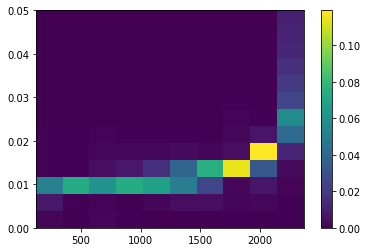

In [9]:
# clean data w/ default spectrogram
freq, ts, Sxx = scisignal.spectrogram(hp)

plt.pcolor(ts, freq, Sxx)		    # plot the spectrogram
plt.ylim(0,0.05)
plt.colorbar()									# colorbar
plt.show()										  # display

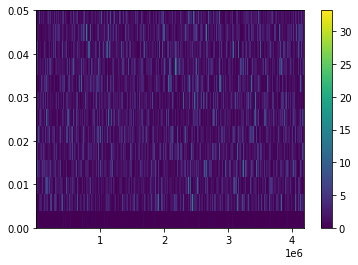

In [10]:
# noisy data w/ default
freq, ts, Sxx = scisignal.spectrogram(data)     # 42 s on colab

plt.pcolor(ts, freq, Sxx)		# plot the spectrogram
plt.ylim(0,0.050)
plt.colorbar()									# colorbar
plt.show()										# display

#### 2.2 Stockwell Transform

##### Main Stockwell Program

In [11]:
import time
import warnings

import numpy as np
import matplotlib.pyplot as plt
from scipy import signal as scisignal

In [12]:
class signal: 
    '''Generate sample signals'''

    def chirp_signal(dt):
        '''Generate a chirp signal for testing 
        Input
                        dt              the sampling interval
        Output          
                        x               chirp signal 
        '''
        t = np.arange(0,3,dt)
        f0 = 50
        f1 = 250
        t1 = 2
        x = np.cos(2*np.pi*t*(f0 + (f1 - f0)*np.power(t, 2)/(3*t1**2)))
        fs = 1/dt

        return x

class dftMethods:
    '''Distrete Fourier Transform class
    NOTE: could be removed and combined with class TimeFrequency
    '''

    def __init__(self, data, sample_rate, fftmethod='numpy'):
        self.data = data
        self.sample_rate = sample_rate
        self.fftmethod = fftmethod
        self.length = len(data)

class TimeFrequency:
    '''Time-Frequency Analysis Methods class'''

    def __init__(self, ts, sample_rate=4096, frange=None, frate=1, overlap = None, method = 'dst', show=True, savefig=False):
        '''
        Input
                        ts                  time-domain data
                        sample_rate         sample_rate, the inverse of sample interval
                        L                   the data length included in each DFT
                        frange              the frequency range
                        frate               the frequency sample rate
                        overlap             the length of overlap between DFTs
                        fftmethod           fft/dft implimentation
                        method              spectrogram method - dtft/dst/dcst
        '''
        self.ts = ts
        self.sample_rate = sample_rate
        self.frange = frange
        self.frate = frate
        self.overlap = overlap
        self.method = method
        self.show = show
        self.savefig = savefig
        self.length = len(self.ts)

        if self.frange == None:
            # use default frange
            self.frange = [30, 500]
    
    def _window(self, N, nleft=0, nright=0):
        ''' *Planck* Window function
        Imput
                        N               the number of data points included in a window
                        nleft           the number of data points to taper on the left
                        nright          the number of data points to taper on the right
        Return
                        win             the normalized window
        Note: Window scaling factor = 1, normalized
        '''
        from scipy.special import expit

        win = np.ones(N)
        if nleft:
            win[0] *= 0
            zleft = np.array([nleft * (1./k + 1./(k-nleft))
                                for k in range(1, nleft)])
            win[1:nleft] *= expit(-zleft)
        if nright:
            win[N-1] *= 0
            zright = np.array([-nright * (1./(k-nright) + 1./k)
                                for k in range(1, nright)])
            win[N-nright:N-1] *= expit(-zright)

        return win

    def _window_normal(self, freq):
        '''Gaussian Window function
        Input 
                        freq            the number of min frequency bins
        Return
                        win             the normalized gaussian window
        Note: Window scaling factor = 1, normalized
        '''
        gauss = scisignal.gaussian(self.length,std=(freq)/(2*np.pi))
        win = np.hstack((gauss,gauss))[self.length//2:self.length//2+self.length]

        return win

    def stransform(self):
        '''The Stockwell Transform'''
       
        Nfreq = [int(self.frange[0]*self.length/self.sample_rate), int(self.frange[1]*self.length/self.sample_rate)]               # the number of data points for min and max frequencies
        tsVal = np.copy(self.ts)            # copy ts values
        power = np.zeros((int((Nfreq[1]-Nfreq[0])/self.frate)+1,self.length), dtype='c8')            #complex64 C
        tsFFT = np.fft.fft(tsVal)
        vec = np.hstack((tsFFT, tsFFT))
        
        if self.frange[0] == 0:
            power = np.mean(tsVal)*np.ones(self.length)
        else:
            power[0] = np.fft.ifft(vec[Nfreq[0]:Nfreq[0]+self.length]*self._window_normal(Nfreq[0]))
        for i in range(self.frate, (Nfreq[1]-Nfreq[0])+1, self.frate):
            power[int(i/self.frate)] = np.fft.ifft(vec[Nfreq[0]+i:Nfreq[0]+i+self.length]*self._window_normal(Nfreq[0]+i))

        return np.abs(power)

    def get_freq_Hz(self, ks):
        '''Get the frequency label in Hz
        Input
                        ks              the freqeuncy array
        Output
                        ksHz            the frequency array in Hz
        ''' 
        ksHz = ks*self.sample_rate/self.length
        ksHz = [int(i) for i in ksHz]              #to be simplified
          
        return ksHz

    def plot(self):
        '''Generate the spectrogram
        methods: stft / dst / dcst
        '''
        if self.method == 'stft':
            f, t, Sxx = scisignal.spectrogram(
                                self.ts, 
                                self.sample_rate,
                                nperseg=128,
                                noverlap=64, 
                                nfft=5000, 
                                scaling='spectrum'
                            )
           
            plt.figure(figsize=(12,9))
            plt.pcolor(t,f, Sxx, cmap ='jet')
            plt.ylabel('Frequency [Hz]')
            plt.xlabel('Time [sec]')
            #plt.xlim(7.5,15)
            plt.ylim(0,300)
            plt.colorbar()

        elif self.method == 'dst':

            # s table
            sTable = self.stransform()
            # y axis
            self.fscale = int(self.length/self.sample_rate)
            y_sticksN = 10
            ks = np.linspace(self.frange[0], self.frange[1]*self.fscale, y_sticksN)
            ksHz = self.get_freq_Hz(ks)

            # x axis
            x_sticksN = 10
            ts = np.linspace(0, sTable.shape[1], x_sticksN)
            tsSec = ["{:4.2f}".format(i) for i in np.linspace(0, sTable.shape[1]/self.sample_rate, x_sticksN)]

            extent=(0,sTable.shape[1], self.fscale*self.frange[0], self.fscale*self.frange[1])
    
            plt.figure(figsize=(12,9))
            plt.imshow(sTable, origin='lower', extent=extent, aspect='auto')
            plt.xticks(ts,tsSec)
            plt.yticks(ks,ksHz) 
            plt.xlabel("Time (sec)")
            plt.ylabel("Freq (Hz)")
            plt.colorbar()
        
        elif self.method == 'dcst':
            pass
        else:
            warnings.warn('Time-Freqeuncy method not supported.')

        if self.show:
            plt.show()
        
        if self.savefig:
            plt.savefig(str(self.method)+str(time.time())+'.png')
        
        return

In [13]:
# inspect the formate of our clean hp data
print(hp)

[-0.02223267 -0.02195683 -0.02163434 ... -0.         -0.
 -0.        ]


##### A Scipy STFT w/ More Details

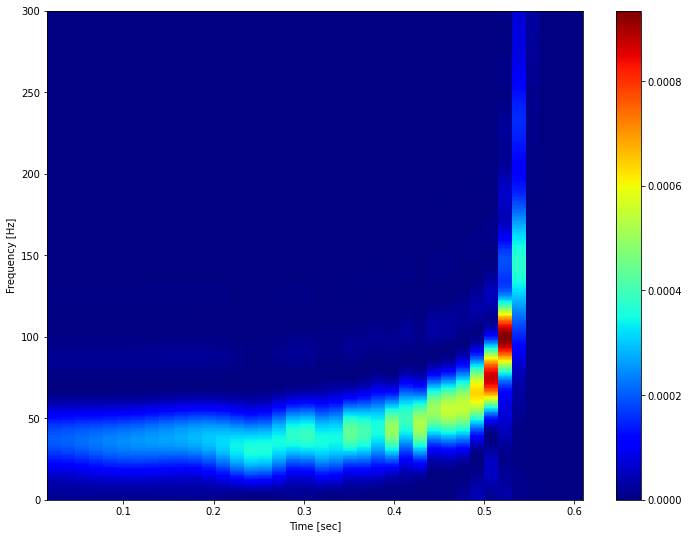

In [14]:
# clean data using DTFT through Stockwell Transform code
hpS = TimeFrequency(hp, sample_rate = sample_rate, method='stft', show=True, savefig=False).plot()

# clearly this STFT/DTFT spectrogram is much more detailed than the previous default Scipy spectrogram
# as the number of fft performed was drastically increased to 5000

# To be worked on ...


In [15]:
# noisy data using DTFT through Stockwell Transform code
# crashes due to high RAM
hpS = TimeFrequency(data, sample_rate = sample_rate, method='stft', show=True, savefig=False).plot()

KeyboardInterrupt: ignored

## GWpy Constant Q Transform

In [ ]:
! pip install -q 'gwpy==1.0.1'
from gwpy.timeseries import TimeSeries as GWTimeSeries

In [ ]:
hpGw = GWTimeSeries(hp, dt = 1/sample_rate, t0=0)
print(len(hpGw))

hpQ = hpGw.q_transform()
plot = hqQ.plot()
plot.colorbar(label="Normalised energy")